#  This script is written for preprocess EEG, EMG for RJ paradigm (both iMC and iVC are included) iVC: isokinetic/isovelocity contraction. This scripts is organized as follows: iMC prep from a to z then the synthesized function. iVC prep fcs are provided elsewhere

##  EMG processing: filtering low-pass: 200Hz, down sampling to 500Hz, then high pass 10 Hz
##  Reason: filter before downsampling to mitigate the distortion caused by aliasing. If a discrete-time signal's baseband spectral support is not limited to an interval of width 2 π / M radians, downsampling by M results in aliasing. 
## Link: https://dsp.stackexchange.com/questions/31843/aliasing-after-downsampling

## Specification of customization (things have to be changed):
- contraction_type can be either 'iMC' or 'iVC'
- session_idx for iMC is 's01' (pre-TMS) and 's02' (after-TMS), for iVC can be 's01' to 's06' with 's01'-'s03' prior to TMS
- please note that in official data processing, each subject can have only iMC or iVC data

## The pipeline for eeg preprocessing is
- alignment (crop the data before the onset of EMG recording)
- visually spot bad channels
- (to be discussed) whether to use 0.5hz high-pass, in my opinion, the 0.5hz is essencial to get rid of slow drift before thresholding. This is changed to 1Hz
- epoching and thresholding
- ICA fitting and exclusion

## The pipeline for emg prep
- alignment
- 10-200Hz band-pass filter
- epoch, resample


## Data integration

## Some notes for implementation:
- during iMC, the event markers is right after the onset of biometrics, and we select 18 second out of contraction phrase (20s) as validated data.  
- Things to be done: MI part (processing part to see the effect) - the report part, the function part

# Step 0: Global definition
The dict and relating script should be update/rerun every time the user spot a bad channel

In [6]:
bad_eeg_chs = {'2':
               {'iMC':{'s01':['T8','C3','CP6'],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
                '4':
               {'iMC':{'s01':['Pz','T8'],'s02':['T8']},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               }
              }
ICs2remove = {'2':
               {'iMC':{'s01':[9,10],'s02':[]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               },
                '4':
               {'iMC':{'s01':[0,3],'s02':[0]},
                'iVC':{'s01':[],'s02':[],'s03':[],'s04':[],'s05':[],'s06':[]}
               }
              }

# Step 1 : Visualization of EEG to spot bad channels
note that once the bad channels have been identified, you have to run this script twice to mark the bad channels
- current edition: take care of the .set and naming problem.

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 sec)



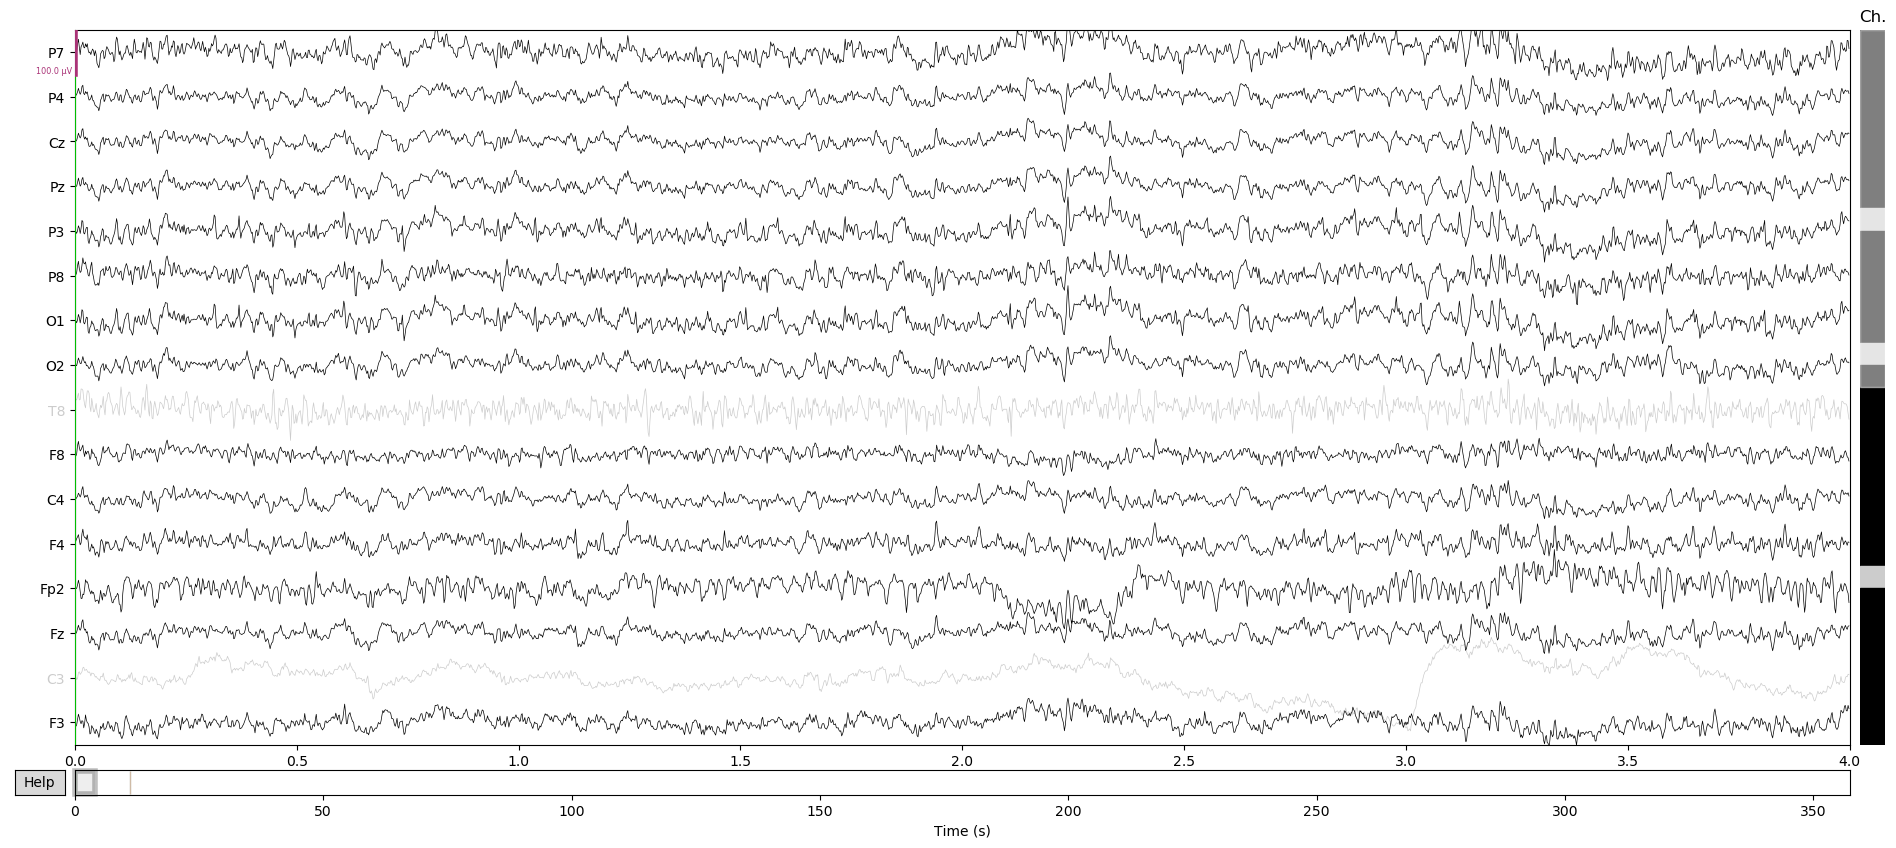

In [3]:
################## Import #####################
import os,mne,numpy as np, pandas as pd
from mne.preprocessing import ICA
%matplotlib qt
#############################################

################## Customization ##################
data_dir = 'D:/Data/MultiEEGEMG_stroke/'
subj_idx = '2'
contraction_type = 'iMC'
session_idx = 's01'
sfreq_emg=1000
sfreq_eeg=500
reject_criteria_eeg = dict(eeg=6e-4)       # 300 μV, do not exclude epochs containing ocular artifact
flat_criteria_eeg = dict(eeg=1e-6)           # 1 μV


################ fName
emg_fName = os.path.join(data_dir,'subj'+subj_idx,'EMG','subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'.txt')
eeg_fName = os.path.join(data_dir,'subj'+subj_idx,'EEG','subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'.set')
ica_dir = os.path.join(data_dir,'subj'+subj_idx,'ica')
epochs_beforeICA_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_beforeICA')
epochs_preped_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_preped')
epochs_hybrid_dir = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid')
if not os.path.exists(ica_dir):
    os.makedirs(ica_dir)
if not os.path.exists(epochs_beforeICA_dir):
    os.makedirs(epochs_beforeICA_dir)
if not os.path.exists(epochs_preped_dir):
    os.makedirs(epochs_preped_dir)
if not os.path.exists(epochs_hybrid_dir):
    os.makedirs(epochs_hybrid_dir)
ica_fName = os.path.join(data_dir,'subj'+subj_idx,'ica','subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_ica.fif')
epochs_beforeICA_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_beforeICA',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_beforeICA_epo.fif')
epochs_preped_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_preped',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_preped_epo.fif')
epochs_hybrid_fName = os.path.join(data_dir,'subj'+subj_idx,'epochs_hybrid',
                                      'subj'+subj_idx+'_'+contraction_type+'_'+session_idx+'_hybrid_epo.fif')
alignmentInfo_fName = os.path.join(data_dir,'subj'+subj_idx,'subj'+subj_idx+'_alignmentInfo.txt')
alignmentInfo = pd.read_csv(alignmentInfo_fName, skiprows=0,
                       sep = ',',engine = 'python')
############################################################

####### eeg reading ###########
raw_eeg = mne.io.read_raw_eeglab(eeg_fName,preload=True)
raw_eeg.set_montage('standard_1020')
raw_eeg.info['bads']=bad_eeg_chs[subj_idx][contraction_type][session_idx]
raw_eeg.crop(tmin = alignmentInfo.loc[(alignmentInfo['sessionIdx']==session_idx) & 
                                      (alignmentInfo['contraction_type']==contraction_type),
                                      'EEG'].values[0]/raw_eeg.info['sfreq'])
raw_eeg.filter(l_freq=1,h_freq=None)
########################################

raw_eeg.plot(scalings=dict(eeg=5e-5),duration = 4, n_channels = 16)

# Step 2: epoch eeg data and fits ICA

In [4]:
###### epoching engineer ############
events,events_id = mne.events_from_annotations (raw_eeg)
iMC_onsets = np.linspace(start = events[0][0]/raw_eeg.info['sfreq']+22.5, 
                         stop = events[0][0]/raw_eeg.info['sfreq']+22.5+45*4,num=5)
iMC_2s_onsets = np.linspace(start = iMC_onsets,stop = iMC_onsets +18,endpoint=False,num=9) # Out of 18
iMC_2s_onsets = np.ravel(iMC_2s_onsets,order = 'F')
durations = [0.]*5*9
descriptions = ['onset_iMC']*5*9
annot = mne.Annotations(onset=iMC_2s_onsets, duration=durations,
                                    description=descriptions,
                                    orig_time=raw_eeg.info['meas_date'])
raw_eeg.set_annotations(annot)
events,events_id = mne.events_from_annotations (raw_eeg)
epochs_eeg = mne.Epochs(raw_eeg,events,reject=reject_criteria_eeg, 
                        flat=flat_criteria_eeg,tmin=0.0,tmax=2,baseline=(0, 0),preload=True)
################################################

############ ICA fitting ###############
ica = ICA(n_components = 0.99,random_state=97)
ica.fit(epochs_eeg)
epochs_eeg.save(epochs_beforeICA_fName,overwrite=True)
ica.save(ica_fName)
################################

Used Annotations descriptions: ['1', 'empty']
Used Annotations descriptions: ['onset_iMC']
45 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 45 events and 1001 original time points ...
    Rejecting  epoch based on EEG : ['FC6']
1 bad epochs dropped
Fitting ICA to data using 29 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Selecting by explained variance: 12 components
Fitting ICA took 0.9s.
Writing ICA solution to D:/Data/MultiEEGEMG_stroke/subj2\ica\subj2_iMC_s01_ica.fif...


<ICA  |  epochs decomposition, fit (fastica): 44044 samples, 12 components, channels used: "eeg">

# Step 3: manual scrutization of ICA

In [5]:
############## ICA checking ############
from mne.preprocessing import read_ica
ica = read_ica(ica_fName)
epochs_eeg = mne.read_epochs(epochs_beforeICA_fName,preload=True)
ica.plot_sources(epochs_eeg,stop=2)
ica.plot_components(inst = epochs_eeg)

# Notes
# ICs2remove = {'2':{'iMC':[6],'s01':[]}}
#########################################

Reading D:/Data/MultiEEGEMG_stroke/subj2\ica\subj2_iMC_s01_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading D:/Data/MultiEEGEMG_stroke/subj2\epochs_beforeICA\subj2_iMC_s01_beforeICA_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
44 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


[<Figure size 975x706.5 with 12 Axes>]

    Using multitaper spectrum estimation with 7 DPSS windows
44 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
44 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
44 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
44 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows
44 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped
    Using multitaper spectrum estimation with 7 DPSS windows

# Step 4: ICA exclusion

In [7]:
ica = read_ica(ica_fName)
epochs_eeg = mne.read_epochs(epochs_beforeICA_fName,preload=True)
ica.exclude = ICs2remove[subj_idx][contraction_type][session_idx]
epochs_preped = epochs_eeg.copy()
ica.apply(epochs_preped)
epochs_preped.interpolate_bads()
epochs_preped.save(epochs_preped_fName,overwrite=True)

Reading D:/Data/MultiEEGEMG_stroke/subj2\ica\subj2_iMC_s01_ica.fif ...
Now restoring ICA solution ...
Ready.
Reading D:/Data/MultiEEGEMG_stroke/subj2\epochs_beforeICA\subj2_iMC_s01_beforeICA_epo.fif ...
    Found the data of interest:
        t =       0.00 ...    2000.00 ms
        0 CTF compensation matrices available
44 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Transforming to ICA space (12 components)
Zeroing out 2 ICA components
    Automatic origin fit: head of radius 91.4 mm
Computing interpolation matrix from 29 sensor positions
Interpolating 3 sensors


# Step 5: emg preprocessing and data integration 
Note: only the eeg filter and event information remains

In [9]:
############# emg reading ##############
ch_types = ['emg']*8
ch_names = []
for idx in range(8):
    ch_names.append('emg'+str(idx+1))
emg_data = pd.read_csv(emg_fName, header = None,skiprows=3, 
                       sep = ' ',usecols=np.arange(0,8),skipfooter=0,engine = 'python')
############### alignment 
emg_data= emg_data.iloc[alignmentInfo.loc[(alignmentInfo['sessionIdx']==session_idx) & 
                                      (alignmentInfo['contraction_type']==contraction_type),
                                      'EMG'].values[0]:,:].values
############## low-pass filter
emg_data=emg_data.T/1e6
emg_data = mne.filter.filter_data(emg_data,sfreq=1000,l_freq=10,h_freq=200)
############## epoch emg data
info = mne.create_info(ch_names=ch_names, sfreq=sfreq_emg, ch_types=ch_types)
raw_emg = mne.io.RawArray(emg_data, info)
############ get dropped epoch idx from eeg, then delete the onset        
epoch_idx = 0
bad_epochs_idx=[]
for i in epochs_eeg.drop_log:
    if i==[]:
        epoch_idx+=1
    else:
        bad_epochs_idx.append(epoch_idx)
        epoch_idx+=1
for idx in sorted(bad_epochs_idx,reverse=True):
    iMC_2s_onsets= np.delete(iMC_2s_onsets,idx) # no need to *2, since the iMC_2s_onsets is the time
durations = [0.]*len(iMC_2s_onsets)
descriptions = ['onset_iMC']*len(iMC_2s_onsets)
annot_emg = mne.Annotations(onset=iMC_2s_onsets, duration=durations,
                                    description=descriptions,
                                    orig_time=raw_emg.info['meas_date'])
raw_emg.set_annotations(annot_emg)
events,events_id = mne.events_from_annotations (raw_emg)
epochs_emg = mne.Epochs(raw_emg,events,tmin=0.0,tmax=2+1/1000,baseline=(0, 0),preload=True)
epochs_emg.resample(sfreq=sfreq_eeg)
####################################################

############## hybrid epoch #######################
epochs_emg.info['highpass'] = epochs_preped.info['highpass']
epochs_emg.info['lowpass'] = epochs_preped.info['lowpass']
epochs_preped.drop_bad()
epochs_emg.events = epochs_preped.events
epochs_hybrid = mne.epochs.add_channels_epochs([epochs_preped,epochs_emg])
epochs_hybrid.save(epochs_hybrid_fName,overwrite=True)

Setting up band-pass filter from 10 - 2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 10.00
- Lower transition bandwidth: 2.50 Hz (-6 dB cutoff frequency: 8.75 Hz)
- Upper passband edge: 200.00 Hz
- Upper transition bandwidth: 50.00 Hz (-6 dB cutoff frequency: 225.00 Hz)
- Filter length: 1321 samples (1.321 sec)

Creating RawArray with float64 data, n_channels=8, n_times=359999
    Range : 0 ... 359998 =      0.000 ...   359.998 secs
Ready.
Used Annotations descriptions: ['onset_iMC']
44 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
Loading data for 44 events and 2002 original time points ...
0 bad epochs dropped


# End of prep scripts

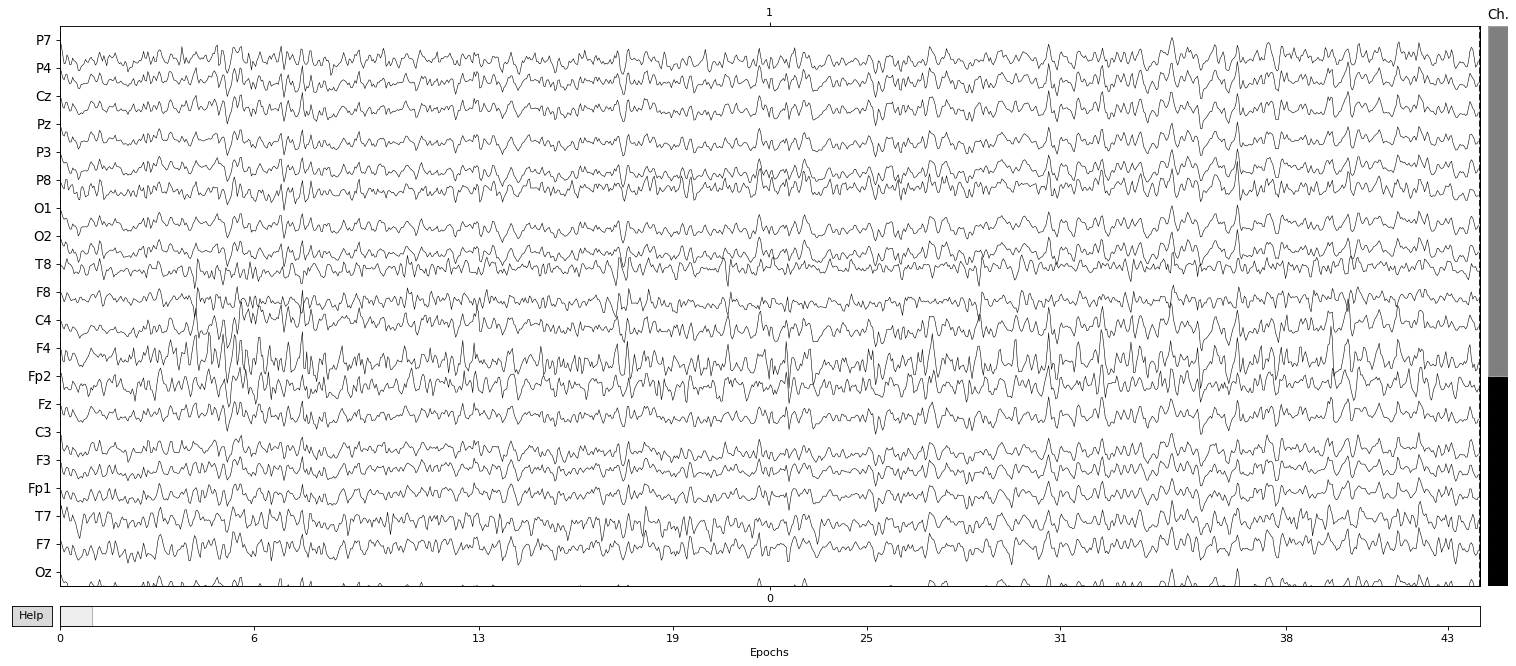

Channels marked as bad: []


In [11]:
epochs_hybrid.plot(n_epochs=1,scalings = 1e-4)